# l2-orderbook example usage

In [1]:
import logging
import os

logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [2]:
from scipy import stats

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import plb

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [7]:
%matplotlib inline

In [8]:
INPUT_DIR='/storage/m2/market_data/raw/crypto/binance/BTCUSDT/orderbook'
SAMPLE_DATE='2020-08-01'

In [9]:
def get_binance_orderbook_snap_delta(input_dir, dt):
    '''Load Binance L2 orderbook snapshot and delta files'''
    
    fn_template = os.path.join(input_dir, 'BTCUSDT_T_DEPTH_{}_depth_'.format(dt))
    snap_fn = fn_template + 'snap.csv'
    update_fn = fn_template + 'update.csv'
    
    needed_cols = ['timestamp', 'side', 'price', 'qty'] 
    
    return pd.read_csv(snap_fn, usecols=needed_cols), pd.read_csv(update_fn, usecols=needed_cols)

In [10]:
def get_binance_tops(input_dir, input_date):
    '''Get tops from binance orderbook data and skip over the start-of-day snapshot data'''
    snap, delta = get_binance_orderbook_snap_delta(input_dir, input_date)
    df = pd.concat([snap, delta])

    df = plb.set_types(df)
    tops = plb.get_tops(df)
    
    return tops.iloc[snap.shape[0]:]

In [11]:
%%time
tops = get_binance_tops(INPUT_DIR, SAMPLE_DATE)

CPU times: user 48.3 s, sys: 8.57 s, total: 56.9 s
Wall time: 56.9 s


In [12]:
tops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640551 entries, 15797 to 13656347
Data columns (total 35 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   ts       uint64
 1   b_0      uint32
 2   bq_0     uint32
 3   b_1      uint32
 4   bq_1     uint32
 5   b_2      uint32
 6   bq_2     uint32
 7   b_3      uint32
 8   bq_3     uint32
 9   b_4      uint32
 10  bq_4     uint32
 11  b_5      uint32
 12  bq_5     uint32
 13  b_6      uint32
 14  bq_6     uint32
 15  b_7      uint32
 16  bq_7     uint32
 17  a_0      uint32
 18  aq_0     uint32
 19  a_1      uint32
 20  aq_1     uint32
 21  a_2      uint32
 22  aq_2     uint32
 23  a_3      uint32
 24  aq_3     uint32
 25  a_4      uint32
 26  aq_4     uint32
 27  a_5      uint32
 28  aq_5     uint32
 29  a_6      uint32
 30  aq_6     uint32
 31  a_7      uint32
 32  aq_7     uint32
 33  b_total  uint32
 34  a_total  uint32
dtypes: uint32(34), uint64(1)
memory usage: 1.8 GB


## EDA

In [13]:
tops['spread']  = tops['a_0'] - tops['b_0']
tops['mid_price'] = tops['b_0'] + tops['spread']

In [14]:
tops['b_qty'] = tops[[c for c in tops.columns if c.startswith('bq_')]].sum(axis=1)
tops['a_qty'] = tops[[c for c in tops.columns if c.startswith('aq_')]].sum(axis=1)
tops['tops_imbalance_delta'] = ((tops['b_qty'] - tops['a_qty']) )

In [15]:
sample = tops.tail(100000)

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 3

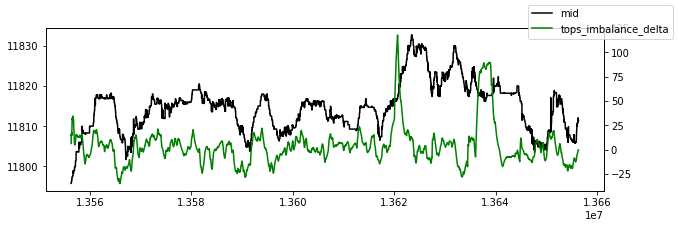

In [17]:
ax = (sample['mid_price']/100).plot(label='mid', color='black')

ax2 = ax.twinx()
(sample['tops_imbalance_delta']/1000).ewm(500).mean().plot(ax=ax2, color='green')

ax.figure.legend()
plt.show()